# MNIST Digit Classification with PyTorch Neural Networks

This notebook demonstrates how to build and train neural networks using PyTorch to classify handwritten digits from the MNIST dataset.

## 1. Import Required Libraries

Import PyTorch, torchvision, matplotlib, and other necessary libraries for building and training neural networks.

In [1]:
import torch
import torch.nn as nn   
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader


# set device
if (torch.cuda.is_available()):
    device = torch.device('cuda') # use GPU if available
elif (torch.backends.mps.is_available()):
    device = torch.device('mps')  # use Metal Performance Shaders (MPS) if available
else:
    device = torch.device('cpu')  # use CPU as a fallback
print(f'Using device: {device}')

Using device: mps


## 2. Load and Explore MNIST Dataset

Load the MNIST dataset using torchvision.datasets and create data loaders for training and testing.

In [2]:
# Define transform to convert images to tensors and normalize
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean and std
])

# create a transform to augment data
augment_transform = transforms.Compose([
    transforms.RandomRotation(10),  # rotate the image by a random angle between -10 and 10 degrees
    transforms.RandomAffine(0, translate=(0.1, 0.1)),  # translate the image by a random fraction of the image size
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data', 
                                         train=True, 
                                         transform=transform, 
                                         download=True)

test_dataset = torchvision.datasets.MNIST(root='./data', 
                                        train=False, 
                                        transform=transform, 
                                        download=True)

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f'Training samples: {len(train_dataset)}')
print(f'Test samples: {len(test_dataset)}')
print(f'Number of classes: {len(train_dataset.classes)}')
print(f'Classes: {train_dataset.classes}')

Training samples: 60000
Test samples: 10000
Number of classes: 10
Classes: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


## 3. Visualize Sample Images

Plot a grid of sample MNIST digit images with their corresponding labels using matplotlib.

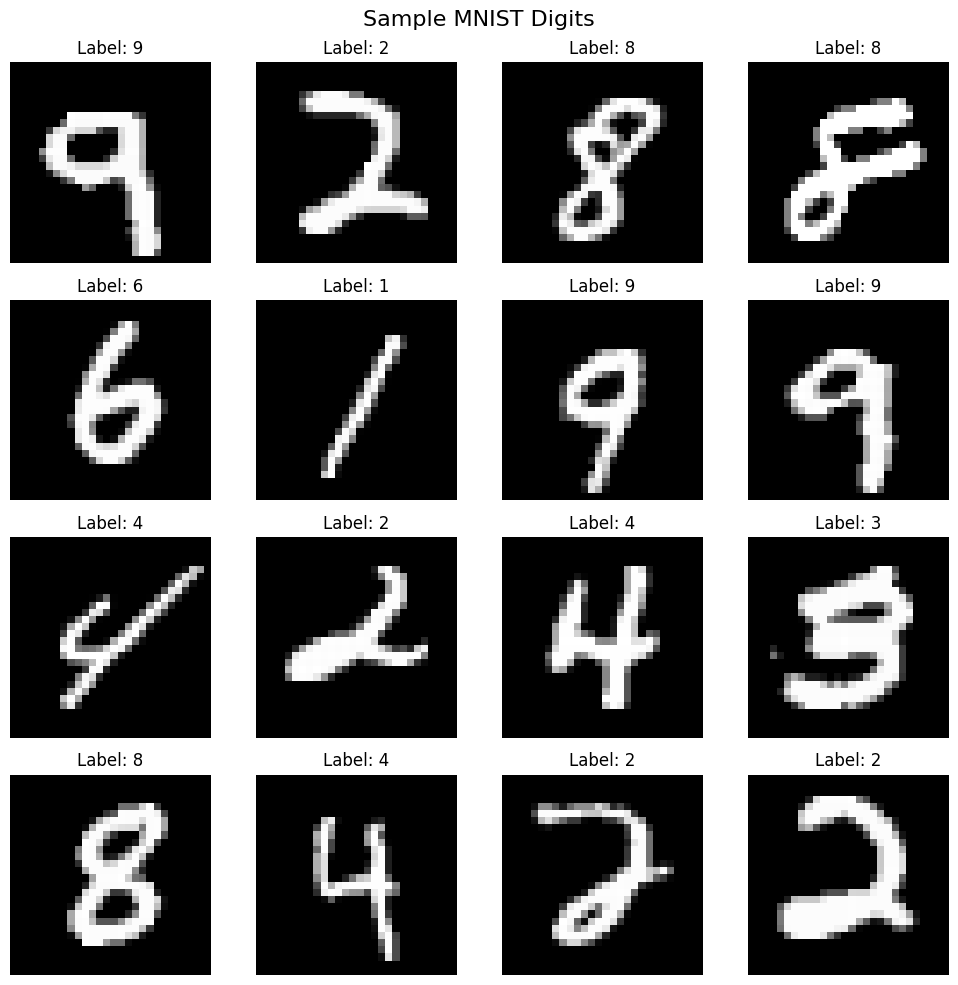

In [3]:
# Function to show images
def show_sample_images(dataset, num_samples=16):
    # Create a figure with subplots
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    fig.suptitle('Sample MNIST Digits', fontsize=16)
    
    for i in range(num_samples):
        # Get a random sample
        idx = np.random.randint(0, len(dataset))
        image, label = dataset[idx]
        
        # Convert tensor to numpy and remove channel dimension
        image_np = image.squeeze().numpy()
        
        # Plot the image
        row = i // 4
        col = i % 4
        axes[row, col].imshow(image_np, cmap='gray')
        axes[row, col].set_title(f'Label: {label}')
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()

# Show sample images from training dataset
show_sample_images(train_dataset)

## 4. Data Preprocessing and Transformation

The data preprocessing is already handled in the dataset loading step. Let's examine the shape and properties of our data.

In [4]:
# Examine data properties
sample_data, sample_label = next(iter(train_loader))
print(f'Batch shape: {sample_data.shape}')
print(f'Label shape: {sample_label.shape}')
print(f'Data type: {sample_data.dtype}')
print(f'Data range: [{sample_data.min():.3f}, {sample_data.max():.3f}]')

# Each image is 28x28 pixels, flattened to 784 features for our neural network
input_size = 28 * 28  # 784
num_classes = 10
print(f'Input size (flattened): {input_size}')
print(f'Number of classes: {num_classes}')

Batch shape: torch.Size([64, 1, 28, 28])
Label shape: torch.Size([64])
Data type: torch.float32
Data range: [-0.424, 2.821]
Input size (flattened): 784
Number of classes: 10


## 5. Define Neural Network Architecture

Create a neural network class using torch.nn.Module with fully connected layers for digit classification.

In [5]:
import sys
sys.path.insert(0, 'iterations')
from iter11 import MNISTNet
# Create the model and move to device
model = MNISTNet().to(device)


# Print model architecture
print("Model Architecture:")
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")

Model Architecture:
MNISTNet(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 1, kernel_size=(1, 1), stride=(1, 1))
    (7): ReLU()
  )
  (fc1): Linear(in_features=49, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)

Total parameters: 20,331


## 6. Set Up Training Parameters

Define loss function, optimizer, learning rate, and other hyperparameters for training.

In [6]:
# Training parameters
learning_rate = 0.001
num_epochs = 1

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print(f"Learning rate: {learning_rate}")
print(f"Number of epochs: {num_epochs}")
print(f"Loss function: {criterion}")
print(f"Optimizer: {optimizer}")

Learning rate: 0.001
Number of epochs: 1
Loss function: CrossEntropyLoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


## 7. Train the Neural Network

Implement the training loop with forward pass, loss calculation, backpropagation, and parameter updates.

In [7]:
# Training loop
train_losses = []
train_accuracies = []

print("Starting training...")
model.train()

for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (data, targets) in enumerate(train_loader):
        # Move data to device
        data, targets = data.to(device), targets.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(data)
        loss = criterion(outputs, targets)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
        
        # Print progress every 200 batches
        if batch_idx % 200 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx}/{len(train_loader)}], '
                  f'Loss: {loss.item():.4f}')
    
    # Calculate epoch statistics
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    
    print(f'Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

print("Training completed!")

Starting training...
Epoch [1/1], Step [0/938], Loss: 2.3031
Epoch [1/1], Step [200/938], Loss: 0.3073
Epoch [1/1], Step [400/938], Loss: 0.1455
Epoch [1/1], Step [600/938], Loss: 0.0859
Epoch [1/1], Step [800/938], Loss: 0.1684
Epoch [1/1] - Loss: 0.2948, Accuracy: 90.71%
Training completed!


## 8. Evaluate Model Performance

Test the trained model on the test dataset and calculate accuracy metrics.

In [8]:
# Evaluate the model on test data
model.eval()
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for data, targets in test_loader:
        data, targets = data.to(device), targets.to(device)
        outputs = model(data)
        loss = criterion(outputs, targets)
        
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.2f}% ({correct}/{total})')

Test Loss: 0.1112
Test Accuracy: 96.54% (9654/10000)


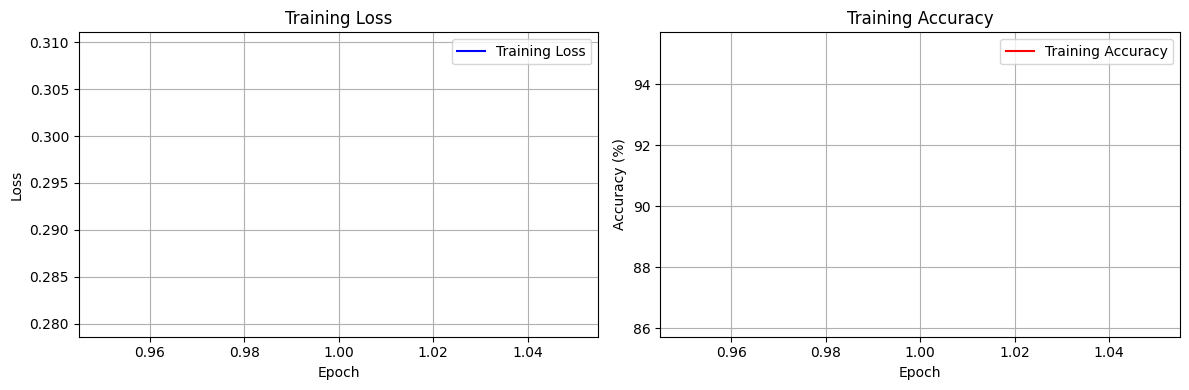

In [9]:
# Plot training progress
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot loss
ax1.plot(range(1, num_epochs + 1), train_losses, 'b-', label='Training Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss')
ax1.legend()
ax1.grid(True)

# Plot accuracy
ax2.plot(range(1, num_epochs + 1), train_accuracies, 'r-', label='Training Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

## 9. Test on Individual Samples

Make predictions on individual test samples and visualize the results with predicted vs actual labels.

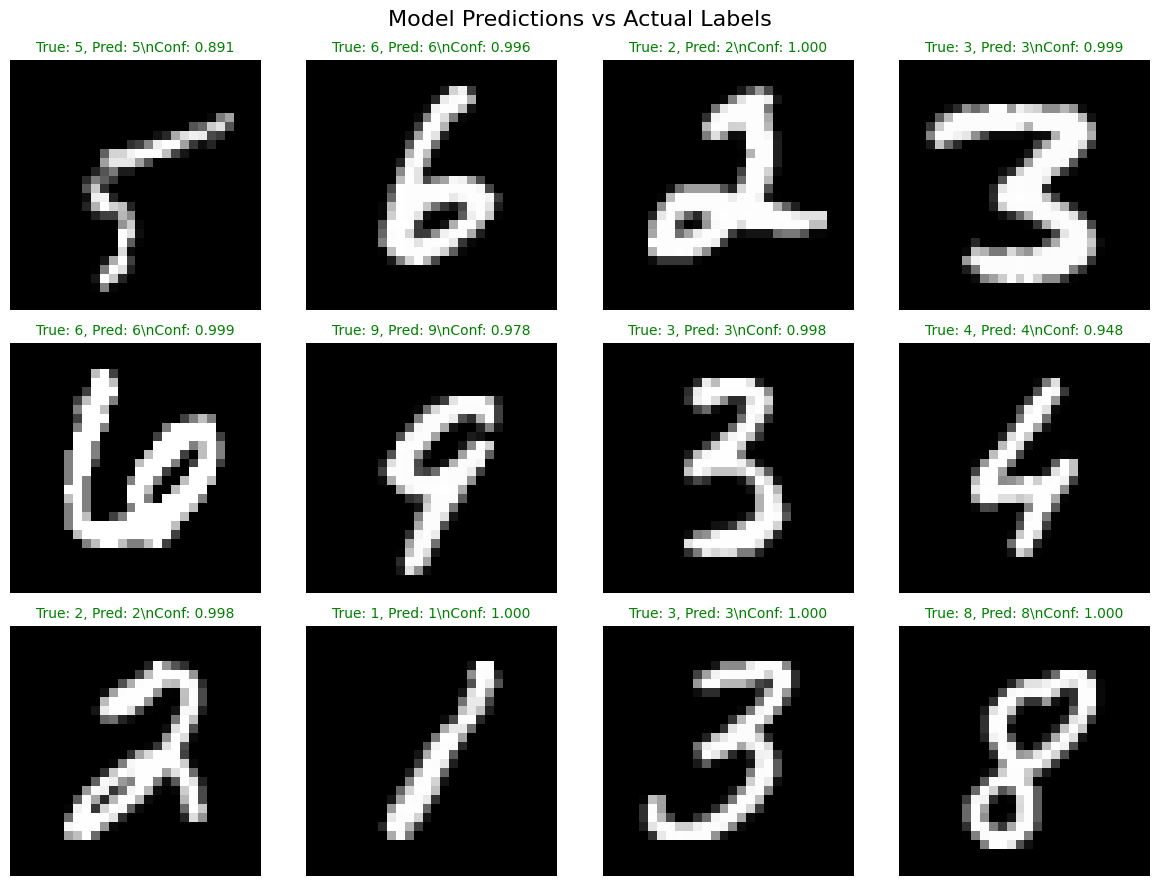

In [10]:
# Function to predict and visualize individual samples
def predict_and_show(model, dataset, num_samples=12):
    model.eval()
    fig, axes = plt.subplots(3, 4, figsize=(12, 9))
    fig.suptitle('Model Predictions vs Actual Labels', fontsize=16)
    
    with torch.no_grad():
        for i in range(num_samples):
            # Get a random sample
            idx = np.random.randint(0, len(dataset))
            image, true_label = dataset[idx]
            
            # Make prediction
            image_batch = image.unsqueeze(0).to(device)  # Add batch dimension
            output = model(image_batch)
            _, predicted_label = torch.max(output, 1)
            predicted_label = predicted_label.item()
            
            # Get prediction probabilities
            probabilities = torch.softmax(output, dim=1)
            confidence = probabilities[0][predicted_label].item()
            
            # Convert tensor to numpy for display
            image_np = image.squeeze().numpy()
            
            # Plot the image
            row = i // 4
            col = i % 4
            axes[row, col].imshow(image_np, cmap='gray')
            
            # Set title with prediction info
            color = 'green' if predicted_label == true_label else 'red'
            title = f'True: {true_label}, Pred: {predicted_label}\\nConf: {confidence:.3f}'
            axes[row, col].set_title(title, color=color, fontsize=10)
            axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()

# Show predictions on test samples
predict_and_show(model, test_dataset)

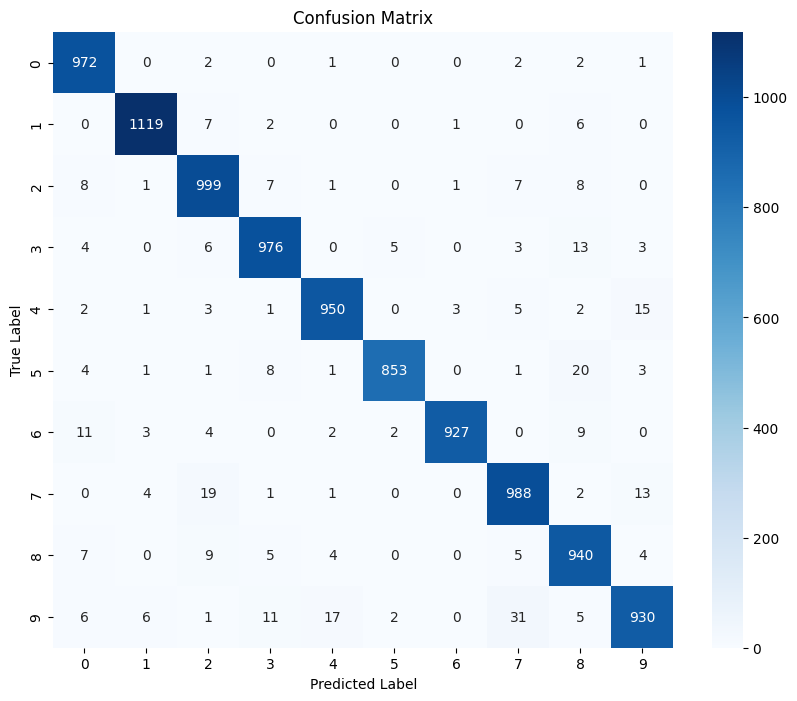

\nPer-class accuracy:
Class 0: 0.992 (99.2%)
Class 1: 0.986 (98.6%)
Class 2: 0.968 (96.8%)
Class 3: 0.966 (96.6%)
Class 4: 0.967 (96.7%)
Class 5: 0.956 (95.6%)
Class 6: 0.968 (96.8%)
Class 7: 0.961 (96.1%)
Class 8: 0.965 (96.5%)
Class 9: 0.922 (92.2%)


In [11]:
# Create confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get all predictions for confusion matrix
model.eval()
all_predictions = []
all_targets = []

with torch.no_grad():
    for data, targets in test_loader:
        data, targets = data.to(device), targets.to(device)
        outputs = model(data)
        _, predicted = torch.max(outputs, 1)
        
        all_predictions.extend(predicted.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

# Create confusion matrix
cm = confusion_matrix(all_targets, all_predictions)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(10), yticklabels=range(10))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Calculate per-class accuracy
class_accuracy = cm.diagonal() / cm.sum(axis=1)
print("\\nPer-class accuracy:")
for i, acc in enumerate(class_accuracy):
    print(f"Class {i}: {acc:.3f} ({acc*100:.1f}%)")

## Conclusion

This notebook demonstrated how to:

1. **Load and explore the MNIST dataset** using PyTorch's built-in dataset functionality
2. **Visualize sample images** to understand the data structure
3. **Build a neural network** with fully connected layers for digit classification
4. **Train the model** using backpropagation and gradient descent
5. **Evaluate performance** on the test set and visualize results
6. **Analyze predictions** with confusion matrix and per-class accuracy

The neural network achieved good performance on MNIST digit classification. You can experiment with:
- Different network architectures (adding more layers, changing layer sizes)
- Different activation functions (ReLU, Sigmoid, Tanh)
- Different optimizers (SGD, RMSprop, AdamW)
- Regularization techniques (dropout, batch normalization)
- Convolutional neural networks for potentially better performance

The MNIST dataset is a great starting point for learning deep learning concepts!